# GP only fit

In [22]:
import os
import pprint
import copy
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
from george.gp import LinAlgError
import yaml
from matplotlib import cm
import rv_analysis_tools as rv
import importlib
importlib.reload(rv)
from astropy.timeseries import LombScargle
import dynesty
import radvel
import pickle

## Target selection

In [23]:
print('Welcome to the joint RV analysis tool!')
print('Which star would you like to analyze?')

star = input('Enter star name:')

print('Loading input file and data...')

# Read input file
try: 
    with open(f'CRAPresults/{star}/input.yaml', 'r') as file:
        yaml_file = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise

Welcome to the joint RV analysis tool!
Which star would you like to analyze?
Loading input file and data...


In [24]:
model_to_run = 'GP_only'

Loading data

In [25]:
data = rv.DataLoader(yaml_file)
i_shared = data.activity_priors['shared_params']

shared_params_str = rv.create_shared_params_str(i_shared)
nplanets_str = rv.create_nplanets_str(data.nplanets)
ecc_str = rv.create_fit_ecc_str(data.fit_ecc)

dir_template = "{parent_dir}/{star}/{crap_dir}/{model_to_run}/{shared_param}/{nplanet}/{fit_ecc}/{sampler}/"

#Create the working path
working_path = f'CRAPresults/{star}/CRAPanalysis/{model_to_run}/{shared_params_str}/{data.sampler}/'
activity_path = f'CRAPresults/{star}/CRAPanalysis/activity/{shared_params_str}/'

# Create the directory
os.makedirs(working_path, exist_ok=True)

# Define GP labels
gp_labels = rv.generate_param_names(['mu', 'log_wn', 'log_amp', 'log_lambda', 'gamma', 'log_Prot'],
                                    i_shared, data.instruments)
print('Done.')

Done.


Numbers of parameters

In [26]:
n_planet_params = 3
n_gp_params = 6

Matplotlib prefererences

In [27]:
# Styling parameters
plt.style.use('ggplot')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'legend.fontsize': 'small',
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small',
    'figure.autolayout': True,
})

colors = plt.cm.jet(np.linspace(1, 0, len(data.instruments)))

Periodogram

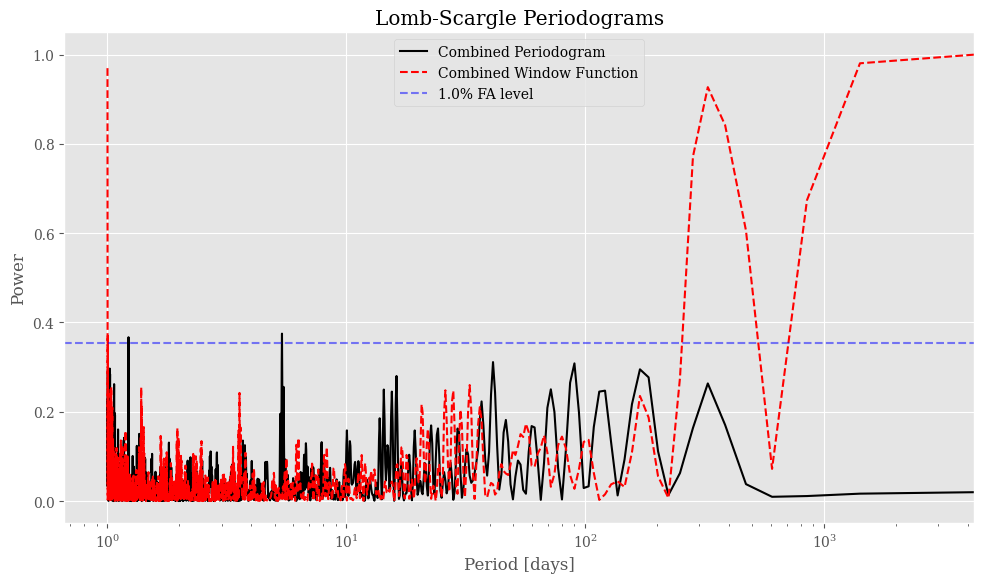

In [28]:
rv.plot_lombscargle_periodograms(data.t_rv, data.y_rv, data.yerr_rv, combined = True, file_path = working_path+'RV_periodogram.png')

Fetch the activity indicators run info

In [29]:
if data.use_indicator: 
    act_post_samples_walkers = np.load(activity_path + 'act_post_samples.npy')
    act_post_samples= act_post_samples_walkers.reshape(-1, act_post_samples_walkers.shape[2])

    # For first guess
    act_med_params = np.median(act_post_samples, axis=0)
    separated_med_params, separated_med_params_dict = rv.separate_gp_params(act_med_params, i_shared, data.instruments)
    act_samples_dict = rv.separate_gp_params_samples(act_post_samples_walkers, i_shared, data.instruments)  # Contains the samples for the parameters of each instrument

Creating the priors and the initial guess 

In [30]:
print(f'Creating initial guess for the RV parameters for GP only model')

# Initialize lists to hold planet parameters and labels
p0 = []
priors = {}  # Dictionary to store the priors
prior_params_names = ['mu', 'noise', 'GP_sigma', 'GP_length', 'GP_gamma', 'GP_Prot']

# Loop over the instruments to construct the GP parameter list
for inst in data.instruments: 
    priors[inst] = copy.deepcopy(data.RV_priors)
    
for instrument in data.instruments: 
    if data.use_indicator:
        # Create the initial vector from the activity indicator
        p0.extend(
            [np.mean(data.y_rv[instrument]), np.log(0.1**2), np.log(np.std(data.y_rv[instrument])**2),
            separated_med_params_dict[instrument][3], separated_med_params_dict[instrument][4], separated_med_params_dict[instrument][5]])
    
        # Add priors for GP parameters
        for idx, param_name in enumerate(prior_params_names):
            if param_name == 'GP_length':
                priors[instrument][param_name] = {
                    'guess': float(np.median(np.sqrt(np.exp(act_samples_dict[instrument][idx])))),
                    'distribution': 'TruncatedNormal',
                    'mean': float(np.median(np.sqrt(np.exp(act_samples_dict[instrument][idx])))),
                    'std': float(np.std(np.sqrt(np.exp(act_samples_dict[instrument][idx])))),
                    'min': data.RV_priors['GP_length']['min'],
                    'max': data.RV_priors['GP_length']['max']
                }
            elif param_name == 'GP_gamma':
                priors[instrument][param_name] = {
                    'guess': float(np.median(act_samples_dict[instrument][idx])),
                    'distribution': 'TruncatedNormal',
                    'mean': float(np.median(act_samples_dict[instrument][idx])),
                    'std': float(np.std(act_samples_dict[instrument][idx])), 
                    'min': data.RV_priors['GP_gamma']['min'], 
                    'max': data.RV_priors['GP_gamma']['max']
                }
            elif param_name == 'GP_Prot':
                priors[instrument][param_name] = {
                    'guess': float(np.median(np.exp(act_samples_dict[instrument][idx]))),
                    'distribution': 'TruncatedNormal',
                    'mean': float(np.median(np.exp(act_samples_dict[instrument][idx]))),
                    'std': float(np.std(np.exp(act_samples_dict[instrument][idx]))), 
                    'min': data.RV_priors['GP_Prot']['min'],
                    'max': data.RV_priors['GP_Prot']['max']
                }
            else: 
                continue

    else:
        p0.extend(rv.juliet_to_george([
            np.mean(data.y_rv[instrument]), 0.1, np.std(data.y_rv[instrument]),
            data.RV_priors['GP_length']['guess'], data.RV_priors['GP_gamma']['guess'], data.RV_priors['GP_Prot']['guess']
        ]))
        priors[instrument] = copy.deepcopy(data.RV_priors)

# Create initial parameter vector: 
p0_vect = rv.params_vector(p0, data.instruments, i_shared, num_planets=data.nplanets, gp_only=True)
comb_p0 = p0_vect.combine()
param_labels = gp_labels

# Save the priors to a file
with open(working_path + 'RV_priors.yaml', 'w') as file:
    yaml.dump(priors, file)


Creating initial guess for the RV parameters for GP only model


## Creating the model

In [31]:
print('Creating GP model...')
model = rv.QP_GP_Model_Group(p0_vect.p, data.t_rv, data.y_rv, data.yerr_rv)
print('Done.')

Creating GP model...
Done.


Look at first guess

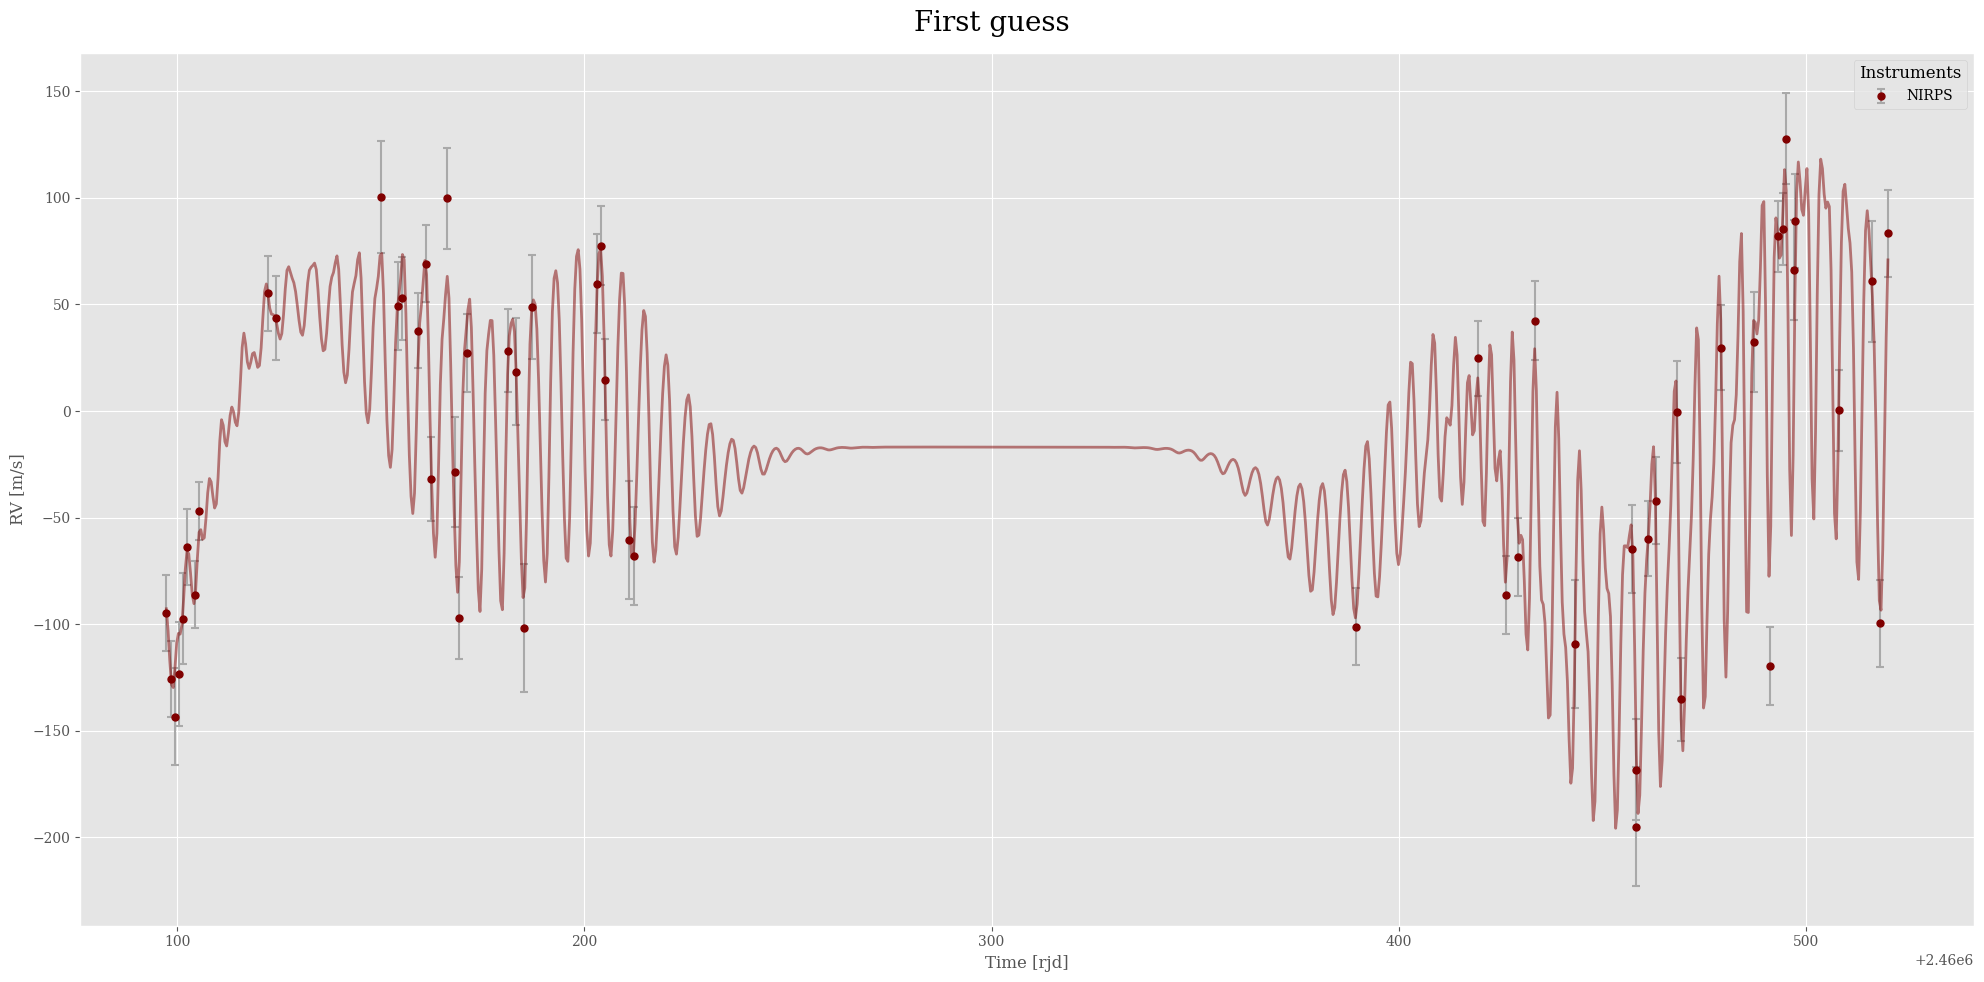

In [32]:
# Plot the RV data and the first guess
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    ax.errorbar(data.t_rv[instrument], data.y_rv[instrument], yerr=data.yerr_rv[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    
    ax.plot(data.t_mod[instrument], model.predict(data.y_rv, data.t_mod)[instrument], color=colors[idx], lw=2, alpha=0.5)
    
    ax.set_xlabel('Time [rjd]')
    ax.set_ylabel('RV [m/s]')
    
    ax.legend(title='Instruments')
plt.suptitle('First guess', fontsize=20)
plt.show()
    

## Run `emcee`

### Creating a combined parameter vector to use in the MCMC run
This is necessary because we want the shared GP parameters to be updated for all instruments at once.

In [33]:
if data.sampler == "emcee":
    # MCMC fit of the GP hyperparameters 
    nwalkers, ndim = 3*len(comb_p0), len(comb_p0)
    num_warmup = 50 * ndim
    num_post_samples = 500 * ndim

    
    sampler = emcee.EnsembleSampler(
                nwalkers,
                ndim,
                rv.emcee_log_post_gp_only,
                args=(model, data, priors, i_shared),
                moves=[emcee.moves.DEMove()])
    
    # Change the dimension of p0 with the number of walkers
    comb_p0_emcee = np.array([comb_p0 + np.random.randn(ndim) * 1e-4 for i in range(nwalkers)])

    if data.run_RV == True:
        print('Running MCMC for the combined model...')
        sampler.run_mcmc(comb_p0_emcee, num_post_samples + num_warmup, progress=True) # Run the MCMC
        
        # Save the samples
        post_samples_walkers = sampler.get_chain(discard=num_warmup)
        post_samples = post_samples_walkers.reshape(-1, post_samples_walkers.shape[2]) # Remove the walkers dimension
        np.save(working_path + 'post_samples_walkers.npy', post_samples_walkers)
        np.save(working_path + 'post_samples.npy', post_samples)  
        
        # Save the log probabilities
        log_prob_samples = sampler.get_log_prob(discard=num_warmup)
        np.save(working_path + 'log_prob_samples.npy', log_prob_samples) 
        
        # Compute the BIC value
        N_data_points = np.sum([len(data.t_rv[instrument]) for instrument in data.instruments])
        bic = rv.bic_calculator(np.max(log_prob_samples), ndim, N_data_points)
        np.savetxt(working_path + f'BIC.txt',
                   np.array([bic]), fmt='%.6f')
        print(f'BIC: {bic}')
        
        print('Done.')
        
    else: 
        print('Loading previous MCMC fit for the combined model...')

Running MCMC for the combined model...


  0%|          | 3/3300 [00:00<02:03, 26.77it/s]

100%|██████████| 3300/3300 [01:51<00:00, 29.48it/s]


BIC: 641.5536637674492
Done.


## Run `dynesty`

In [34]:
model.p

[-16.86790137524328,
 -4.605170185988091,
 8.8023612682939,
 5.614829308868836,
 1.0312494250152153,
 1.6944147361495099]

In [35]:
if data.sampler == 'dynesty': 
    # Set up the Nested Sampler
    ndim = len(comb_p0)

    # Define parameters in relation to ndim
    n_live_points = 10 * ndim  # Number of live points, typically 10 * ndim
    dlogz = 0.1  # Stopping criteria for the evidence
    maxiter = 5000 * ndim  # Maximum number of iterations
    num_warmup = 100 * ndim

    if data.run_RV: 
        sampler = dynesty.NestedSampler(rv.dynesty_log_likelihood_gp_only, rv.dynesty_prior_transform_gp_only, ndim, 
                                        nlive=n_live_points, 
                                        logl_args=(model, data, i_shared), 
                                        ptform_args=(priors, model, data, i_shared))

        # Run the Nested Sampler
        sampler.run_nested(dlogz=dlogz, maxiter=maxiter)
        results = sampler.results
        # Save the results to a .pkl file
        with open(working_path + 'dynesty_results.pkl', 'wb') as f:
            pickle.dump(results, f)
        
        all_log_prob_samples = results.logl
        
        # Smooth the log-probability curve using a moving average
        window_size = 50
        smoothed_log_prob = np.convolve(all_log_prob_samples, np.ones(window_size)/window_size, mode='valid')

        # Calculate the derivative of the smoothed log-probability
        derivative_log_prob = np.diff(smoothed_log_prob)

        # Identify the point where the derivative falls below a threshold and stays there
        threshold = 0.01
        burn_in = next((i for i, v in enumerate(derivative_log_prob) if v < threshold), 0) + window_size

        print(f"Determined burn-in period: {burn_in}")

        # Gather the results: samples and log_prob of all samples
        samples = np.copy(results.samples[burn_in:])  # Array of shape (nsamples, ndim)
        np.save(working_path + 'post_samples.npy', samples)
        
        log_prob = np.copy(results.logl[burn_in:])  # Log-likelihood values for each sample
        np.save(working_path + 'log_prob_samples.npy', log_prob)


        # Extract the evidence (logZ) and its uncertainty (logZerr)
        log_evidence = results.logz[-1]
        log_evidence_err = results.logzerr[-1]
        evidence_filename = working_path + f'log_evidence.txt'
        np.savetxt(evidence_filename, np.array([[log_evidence, log_evidence_err]]), header="log_evidence log_evidence_err", fmt='%.6f')
    
    else: 
        print('Loading previous Nested Sampling fit for the planet + GP model...')
    

Load the already ran target

In [36]:
post_samples = np.load(working_path + 'post_samples.npy')
if data.sampler == 'emcee': post_samples_walkers = np.load(working_path + 'post_samples_walkers.npy')
log_prob_samples = np.load(working_path + 'log_prob_samples.npy')
if data.sampler == 'dynesty': 
    with open(working_path + 'dynesty_results.pkl', 'rb') as f:
        results = pickle.load(f)

Manuel burn-in

In [37]:
# # Manual burn-in 
# if data.sampler == 'dynesty': 
#     burn_in = 600

#     post_samples = results.samples[burn_in:]
#     np.save(working_path + 'post_samples.npy', post_samples)

#     log_prob_samples = results.logl[burn_in:]
#     np.save(working_path + 'log_prob_samples.npy', log_prob_samples)

Traceplot

Plotting traceplot...
Done.


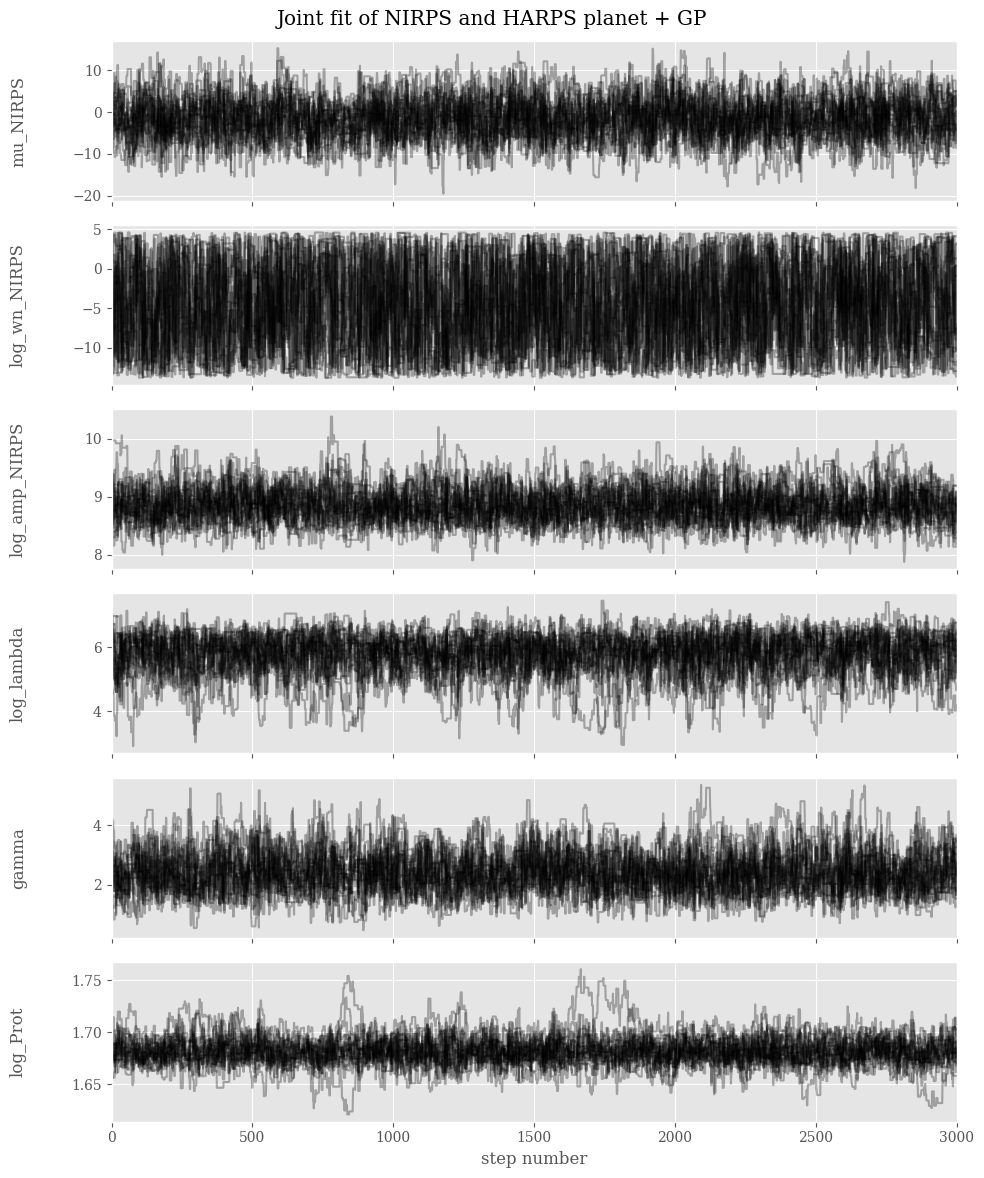

In [38]:
if data.sampler == 'emcee':  
    print('Plotting traceplot...')

    fig, axes = plt.subplots(ndim, figsize=(10, ndim*2), sharex=True)

    for i in range(ndim):
        ax = axes[i]
        ax.plot(post_samples_walkers[:,:, i], "k", alpha=0.3)
        ax.set_xlim(0, len(post_samples_walkers))
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.set_ylabel(param_labels[i])
    axes[-1].set_xlabel("step number")
    plt.suptitle('Joint fit of NIRPS and HARPS planet + GP')
    plt.savefig(working_path + f'traceplot.png')

    print('Done.')

elif data.sampler == 'dynesty': 
    print('Plotting traceplot...')
    
    # Number of parameters
    ndim = len(comb_p0)

    # Create a figure for the trace plot
    fig, axes = plt.subplots(ndim + 1, 1, figsize=(10, 2 * (ndim + 1)), sharex=True)

    # Plot each parameter
    for i in range(ndim):
        axes[i].plot(post_samples[:, i], color='blue', alpha=0.5)
        axes[i].set_ylabel(param_labels[i])
        axes[i].grid(True)

    # Plot the log probability
    axes[ndim].plot(log_prob_samples, color='red', alpha=0.5)
    axes[ndim].set_ylabel('log_prob')
    axes[ndim].set_xlabel('Iteration')
    axes[ndim].grid(True)

    # Add a title to the figure
    fig.suptitle('Trace Plot', fontsize=16)

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    plt.savefig(working_path + f'traceplot.png')
    
    print('Done.')
    
else: 
    print('The selected sampler is not valid')

Cornerplot

Plotting corner plot...
Done.


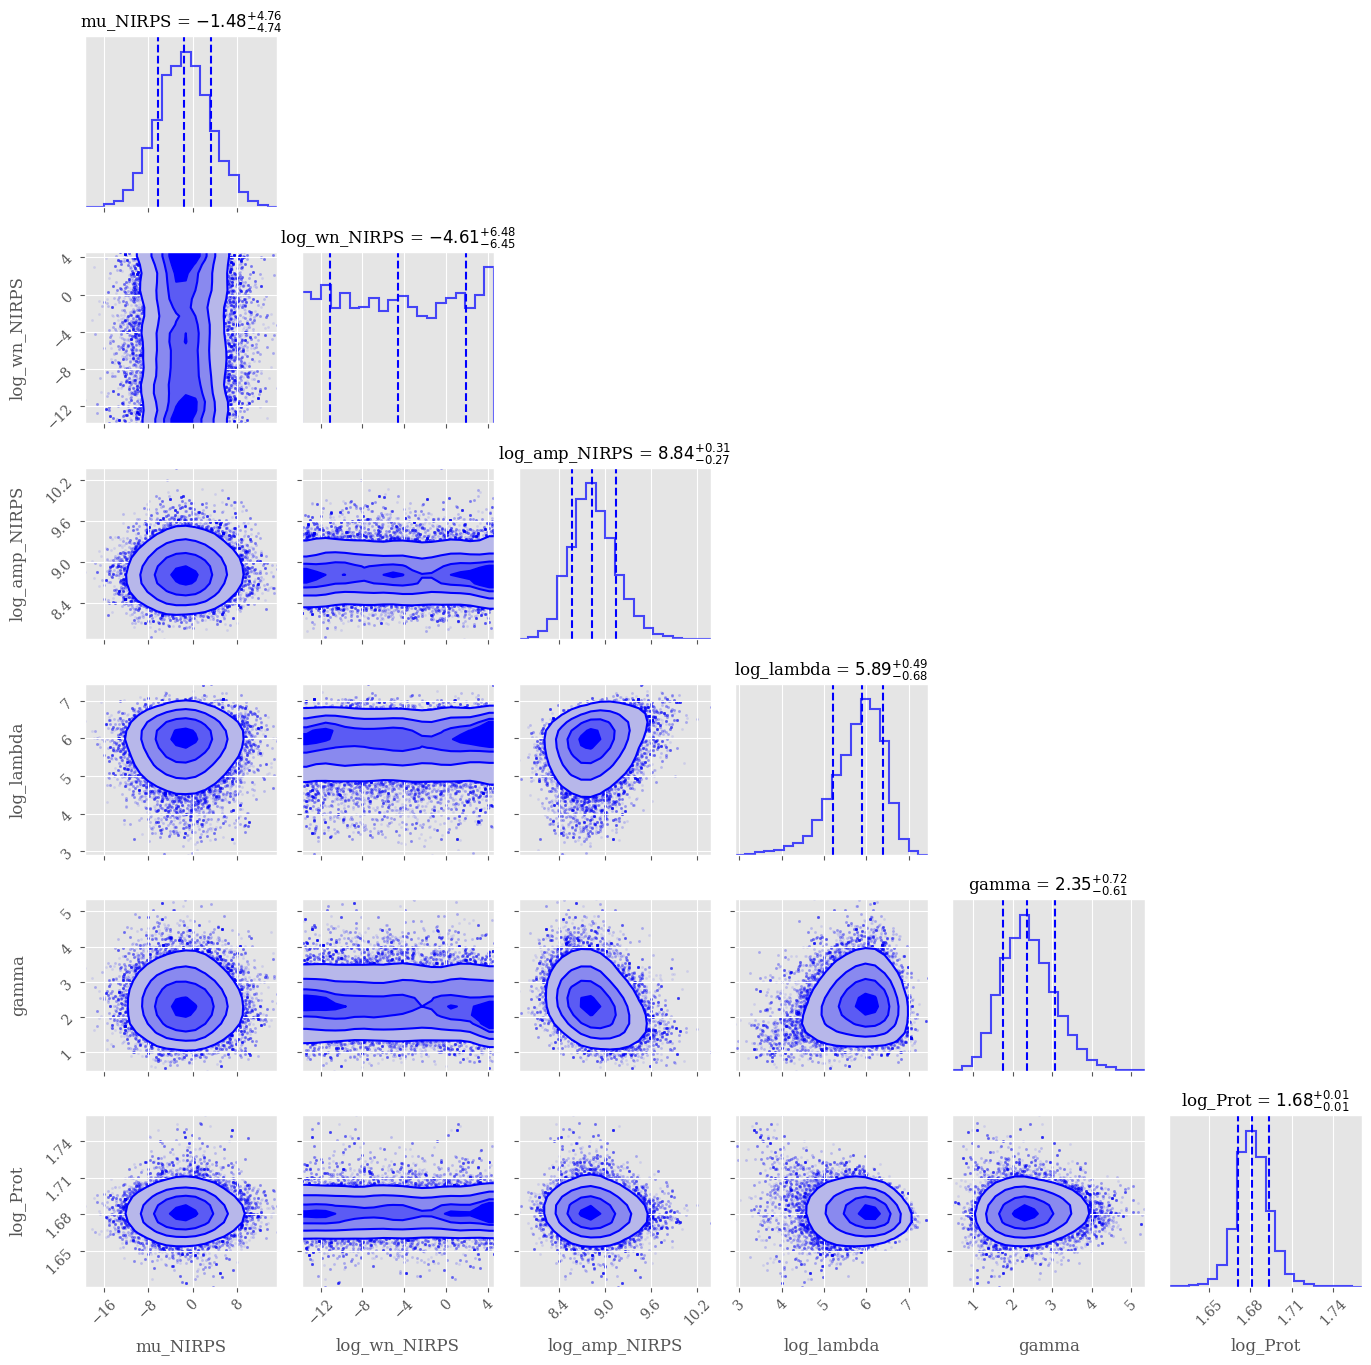

In [39]:
print('Plotting corner plot...')

# Make a corner plot
fig = corner.corner(
    post_samples,
    labels=param_labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    color="blue",  # Set a color scheme (optional)
    hist_kwargs={"linewidth": 1.5, "alpha": 0.7},  # Adjust histogram appearance
    fill_contours=True,  # Show contours for data density
    fill_kw={"cmap": "Blues"},  # Set colormap for contours (optional)
    smooth=True,  # Improve smoothness of contours
    fontsize=10,  # Set font size for labels and tick marks
    truth_color = 'orange',
)

plt.tight_layout()
plt.savefig(working_path + f'cornerplot.png')

print('Done.')

Best parameters

In [40]:
# Get the best parameters
med_params = np.median(post_samples.flatten().reshape(-1, ndim), axis=0)
max_params = rv.get_max_likelihood_params(post_samples.flatten().reshape(-1, ndim), log_prob_samples.flatten())

# Get the uncertainty
errors = np.percentile(post_samples.flatten().reshape(-1, ndim), [16, 84], axis=0)

print('Median likelihood parameters')
print('--------------------------')
# Show the median likelihood parameters
with open(working_path + 'median_likelihood_params.txt', 'w') as text_file:
    for i, label in enumerate(param_labels):
        print(f'{label}: {med_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}')
        text_file.write(f'{label}: {med_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}\n')
    
print('Maximum likelihood parameters')
print('--------------------------')
# Show the maximum likelihood parameters
with open(working_path + 'maximum_likelihood_params.txt', 'w') as text_file:
    for i, label in enumerate(param_labels):
        print(f'{label}: {max_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}')
        text_file.write(f'{label}: {max_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}\n')

Median likelihood parameters
--------------------------
mu_NIRPS: -1.477 - -6.222 + 3.287
log_wn_NIRPS: -4.606 - -11.051 + 1.873
log_amp_NIRPS: 8.836 - 8.569 + 9.144
log_lambda: 5.892 - 5.208 + 6.386
gamma: 2.354 - 1.746 + 3.073
log_Prot: 1.681 - 1.671 + 1.693
Maximum likelihood parameters
--------------------------
mu_NIRPS: -2.032 - -6.222 + 3.287
log_wn_NIRPS: 4.417 - -11.051 + 1.873
log_amp_NIRPS: 8.969 - 8.569 + 9.144
log_lambda: 6.396 - 5.208 + 6.386
gamma: 1.993 - 1.746 + 3.073
log_Prot: 1.677 - 1.671 + 1.693


Choose between median or maximum parameters

In [41]:
best_params = np.copy(max_params)
#best_params = np.copy(med_params)

Creating posterior samples

In [42]:
# Visualize posterior samples and max/median likelihood models
print('Creating posterior samples...')

num_display = 50
maxiter = 100
niter = 0

# Initialize dictionaries to store posterior samples for each instrument
model_post_samples = {instrument: [] for instrument in data.instruments}

while niter < maxiter and all(len(samples) < num_display for samples in model_post_samples.values()):
    n = np.random.randint(len(post_samples))
    
    try:
        gp_samples, gp_samples_dict = rv.separate_gp_params(post_samples[n], i_shared, data.instruments)
        model.update_params(gp_samples)
        for instrument in data.instruments:
            model_post_samples[instrument].append(model.predict(data.y_rv, data.t_mod)[instrument])
        
    except LinAlgError:
        print("LinAlgError")
        print(f"iteration {niter}")
        print("GP hyperparameters:")
        for instrument, gp_model in model.gp_models.items():
            pprint.pprint(gp_model.gp.get_parameter_dict())
    
    niter += 1

# Convert lists to numpy arrays
model_post_samples = {instrument: np.array(samples) for instrument, samples in model_post_samples.items()}

print('Done')

Creating posterior samples...
Done


Separate the best parameters between instruments

In [43]:
best_gp_params, best_gp_params_dict = rv.separate_gp_params(med_params, i_shared, data.instruments)
model.update_params(best_gp_params)
    
# Fetch the noise term of each instrument
noise_terms = {instrument: np.sqrt(data.yerr_rv[instrument]**2 + np.exp(best_gp_params_dict[instrument][1])) for instrument in data.instruments}

Plot the best fit

Plotting the best-fit model and residuals


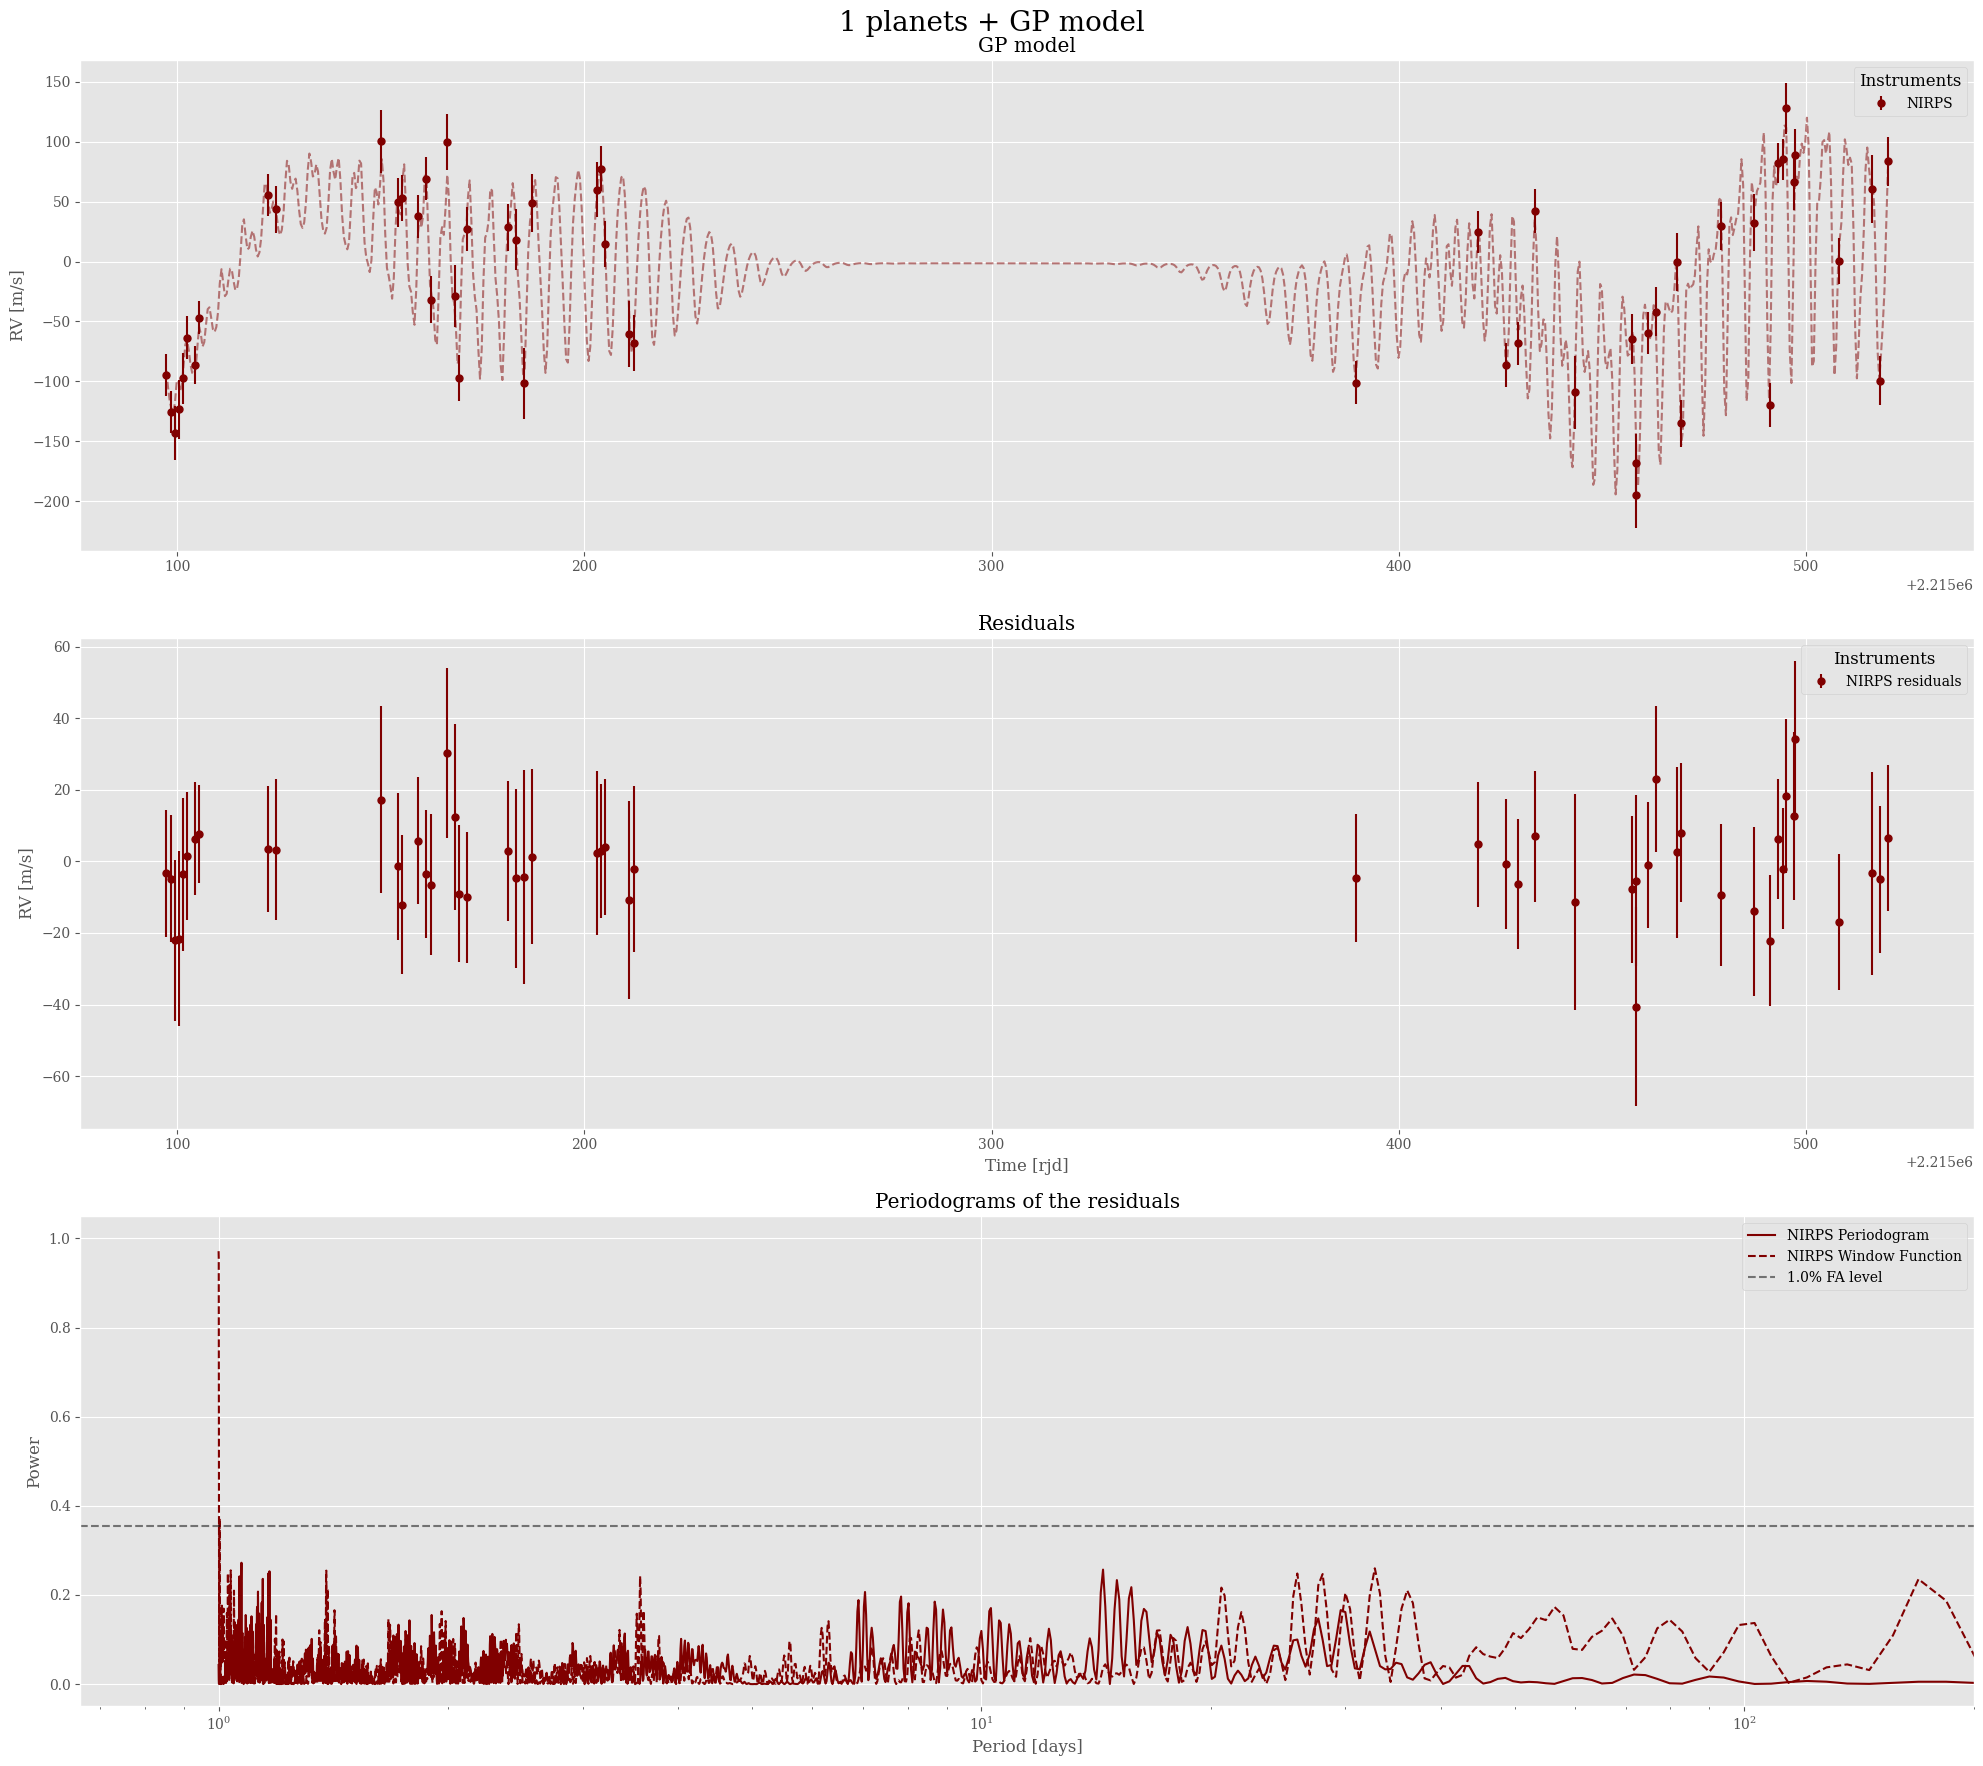

Done.


In [44]:
print('Plotting the best-fit model and residuals')

# Plot the planets + GP model and the samples
fig, axes = plt.subplots(3, 1, figsize=(20, 18), sharex=False)
rjd_off = 245000

# Dictionnaries to store the model predictions
gp_mod_pred_on_data = {}
gp_mod_pred_on_mod_times = {}

# RV offset for each instrument
rv_offset = {}

for idx, instrument in enumerate(data.instruments):
    
    # Offset
    rv_offset[instrument] = best_params[idx]
    
    # Evaluate GP
    gp_mod_pred_on_data[instrument] = model.predict(data.y_rv, data.t_rv)[instrument]
    gp_mod_pred_on_mod_times[instrument] = model.predict(data.y_rv, data.t_mod)[instrument]
    
    # Plot data with error bars
    axes[0].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] , yerr=noise_terms[instrument], fmt="o", ms=5, label=f'{instrument}', color=colors[idx])
    
    # Plot best likelihood
    axes[0].plot(data.t_mod[instrument] - rjd_off, gp_mod_pred_on_mod_times[instrument], color=colors[idx],
                 linestyle='--', linewidth=1.5, alpha=0.5)  # GP model
    
    # Plot residuals
    axes[1].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - gp_mod_pred_on_data[instrument], yerr=noise_terms[instrument], fmt='o', color=colors[idx], label=f'{instrument} residuals')
    
    # Plot the periodogram of the residuals
    ls = LombScargle(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - gp_mod_pred_on_data[instrument], dy=noise_terms[instrument])
    target_fap = 0.01
    fap = ls.false_alarm_level(target_fap)
    freq, power = ls.autopower(maximum_frequency=1.0)
    period = 1 / freq

    ls_window = LombScargle(data.t_rv[instrument] - rjd_off, np.ones_like(data.y_rv[instrument]), dy=noise_terms[instrument], fit_mean=False, center_data=False)
    power_window = ls_window.power(freq)

    axes[2].plot(period, power, color=colors[idx], label=f'{instrument} Periodogram')
    axes[2].plot(period, power_window, color=colors[idx], linestyle='--', label=f'{instrument} Window Function')

axes[2].axhline(fap, linestyle="--", color="black", label=f"{target_fap * 100}% FA level", alpha=0.5)

axes[0].set_title('GP model')
axes[1].set_title('Residuals')
axes[2].set_title('Periodograms of the residuals')
axes[1].set_xlabel('Time [rjd]')
axes[0].set_ylabel('RV [m/s]')
axes[1].set_ylabel('RV [m/s]')
axes[0].legend(title='Instruments')
axes[1].legend(title='Instruments')
axes[2].set_xlabel('Period [days]')
axes[2].set_ylabel('Power')
axes[2].legend()
axes[2].set_xscale('log')
axes[2].set_xlim(0, 200)
plt.suptitle(f'{data.nplanets} planets + GP model', fontsize=20)
plt.savefig(working_path + f'best_fit.png')
plt.show()

print('Done.')

Plotting posterior samples

Plotting model samples
Done.


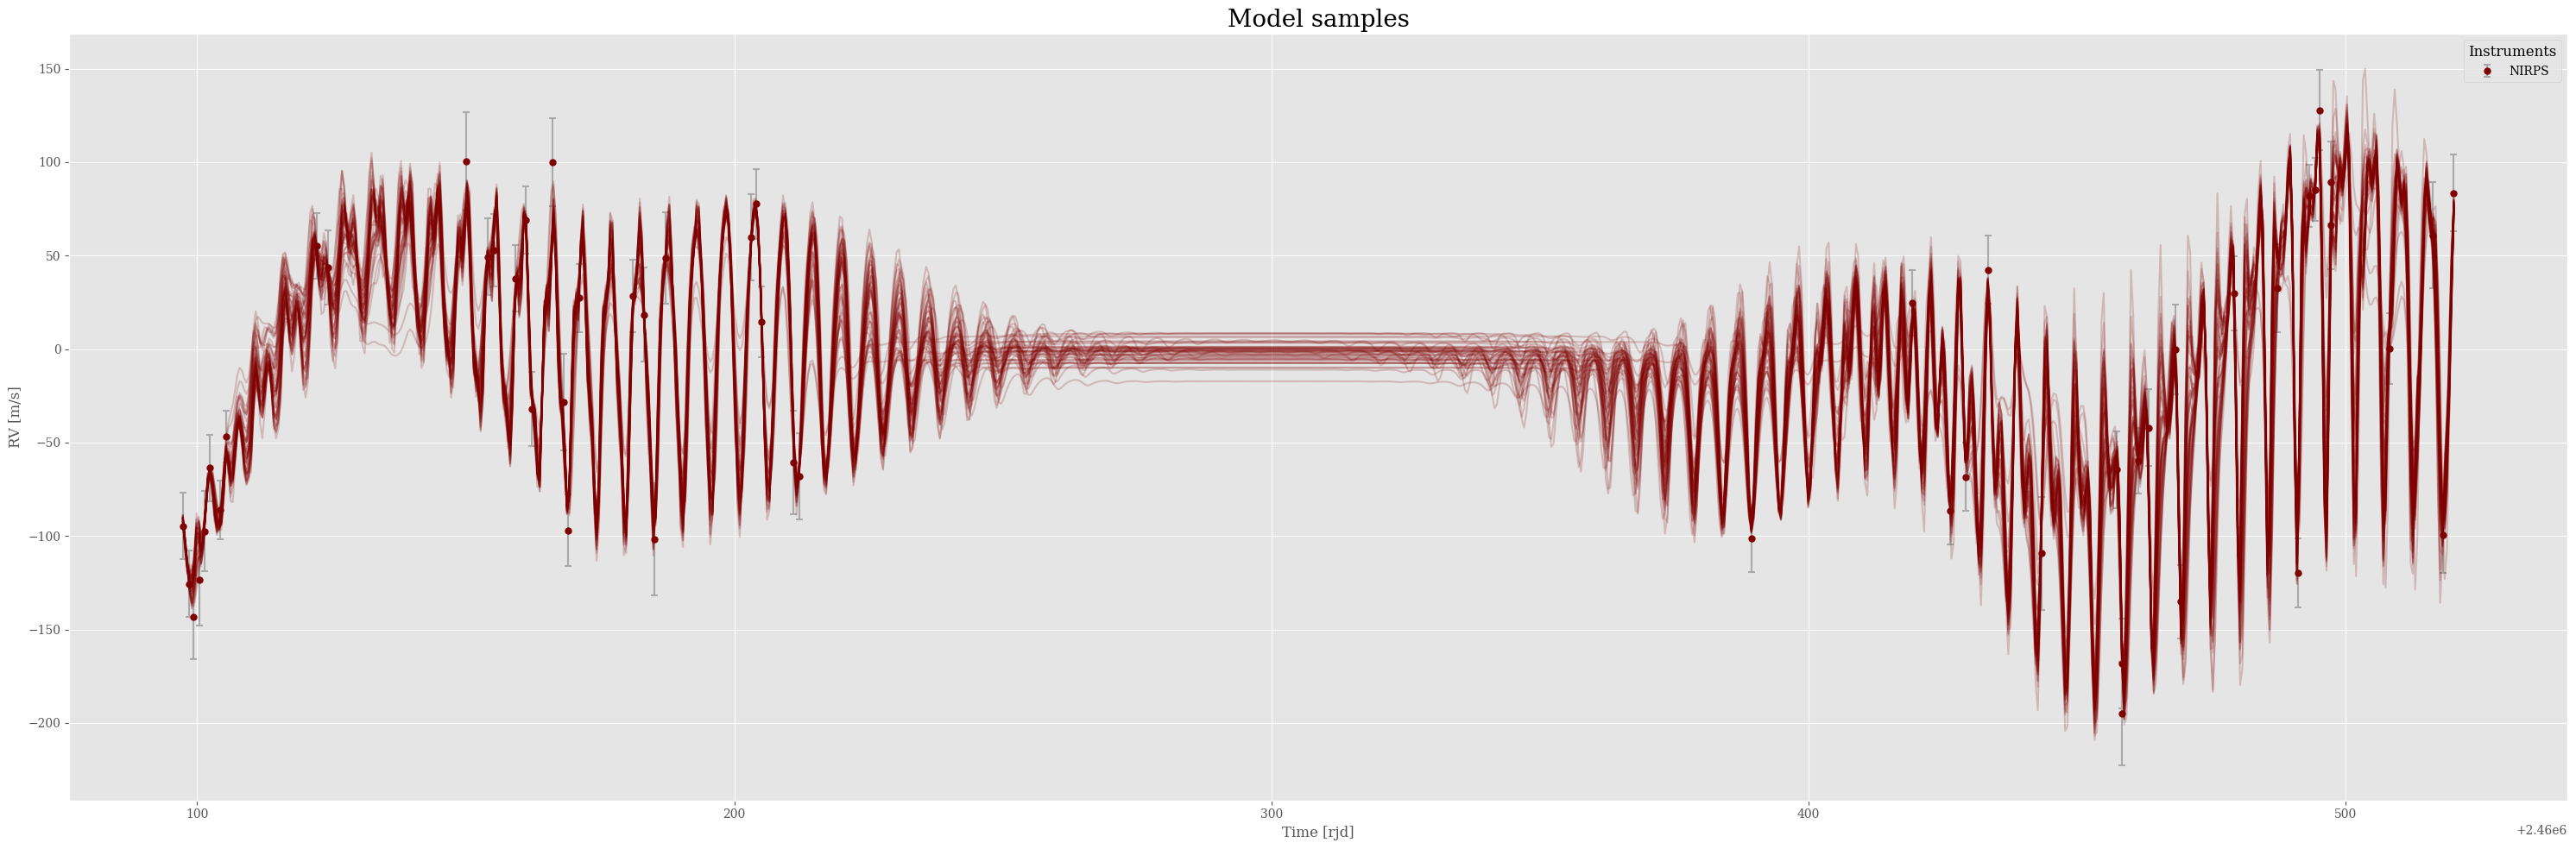

In [45]:
print('Plotting model samples')

fig, ax = plt.subplots(1, 1, figsize=(30, 10))

for idx, instrument in enumerate(data.instruments):
    ax.errorbar(data.t_rv[instrument], data.y_rv[instrument], yerr=noise_terms[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    ax.plot(data.t_mod[instrument], model_post_samples[instrument].T, alpha = 0.2, color = colors[idx])
    
ax.set_xlabel('Time [rjd]')
ax.set_ylabel('RV [m/s]')
ax.legend(title='Instruments')
ax.set_title('Model samples', fontsize = 20)

plt.savefig(working_path + f'planet_model_samples.png')
print('Done.')

In [46]:
# Print the RMS of the residuals
rms = np.sqrt(np.mean([np.sum((np.abs(data.y_rv[instrument] - gp_mod_pred_on_data[instrument]))**2) for instrument in data.instruments]))
np.savetxt(working_path + 'rms.txt', np.array([rms]), fmt='%.6f')
print(f'RMS of the residuals: {rms:.3f} m/s')

# Print the median residual value
median_residual = np.median([np.median(np.abs(data.y_rv[instrument] - gp_mod_pred_on_data[instrument])) for instrument in data.instruments])
np.savetxt(working_path + 'median_residual.txt', np.array([median_residual]), fmt='%.6f')
print(f'Median residual value: {median_residual:.3f} m/s')

RMS of the residuals: 92.574 m/s
Median residual value: 6.298 m/s


In [47]:
print('All done! Hope you will be happy with your results')

All done! Hope you will be happy with your results


Done!